# Wikimedia Enterprise HTML dumps on Spark

Example for how to use the (html dumps)[https://dumps.wikimedia.org/other/enterprise_html/] generated by Wikimedia enterprise in spark pipelines running on the data engineering cluster

## Get data on HDFS

Dowload the data from dumps.wikimedia.org, extract the json files, upload them to hdfs. This process is not ideal. The unpacking of the tar.gz into multiple uncompressed json files is not efficient, and in addition it takes more space on hdfs as the data is not compressed anymore. See https://phabricator.wikimedia.org/T298436 for discussion about data format.

In [ ]:
wget https://dumps.wikimedia.org/other/enterprise_html/runs/20230320/simplewiki-NS0-20230320-ENTERPRISE-HTML.json.tar.gz
mkdir -p html_enterprise/simple
tar -C html_enterprise/simple -I pigz -xf simplewiki-NS0-20230320-ENTERPRISE-HTML.json.tar.gz
hdfs dfs -put html_enterprise/simple/simplewiki_*  html_enterprise/simple

There are some html dumps available on the stat machines on `/mnt/data/xmldatadumps/public/other/enterprise_html/runs/`, but the most recent run is from October 2022. 

I put the html dumps from March 20th 2023 (20230320) for `enwiki` and `simplewiki` on `/wmf/data/research/html_enterprise/`.

In [3]:
import wmfdata
spark = wmfdata.spark.create_session(app_name='enterprise_html', ship_python_env=True)
df = spark.read.json('/wmf/data/research/html_enterprise/enwiki/*ndjson')
df.printSchema()

23/03/30 02:57:47 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


root
 |-- additional_entities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- aspects: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- identifier: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- article_body: struct (nullable = true)
 |    |-- html: string (nullable = true)
 |    |-- wikitext: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- date_modified: string (nullable = true)
 |-- identifier: long (nullable = true)
 |-- in_language: struct (nullable = true)
 |    |-- identifier: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- is_part_of: struct (nullable = true)
 |    |-- identifier: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- license: array (nullable = true)


Compute the histogramm of the size difference between the html and wikitext, in 10kb buckets.

In [11]:
from pyspark.sql import functions as F

kb_bucket = 10

@F.udf(returnType='int')
def kb_diff(html, wikitext):
    if wikitext and html:
        html_kb = len(html.encode('utf-8'))/1024
        wikitext_kb = len(wikitext.encode('utf-8'))/1024
        return int((html_kb-wikitext_kb) / kb_bucket)
    else:
        return None


html_wikitext_diff_hist = (df
    .withColumn('html_wikitext_diff', kb_diff("article_body.html", "article_body.wikitext"))
    .groupby('html_wikitext_diff')
    .count()
    .orderBy(F.col('html_wikitext_diff').asc())
).toPandas()

html_wikitext_diff_hist['html_wikitext_diff'] *= kb_bucket



<AxesSubplot: xlabel='size difference between HTML and wikitext (in KB)'>

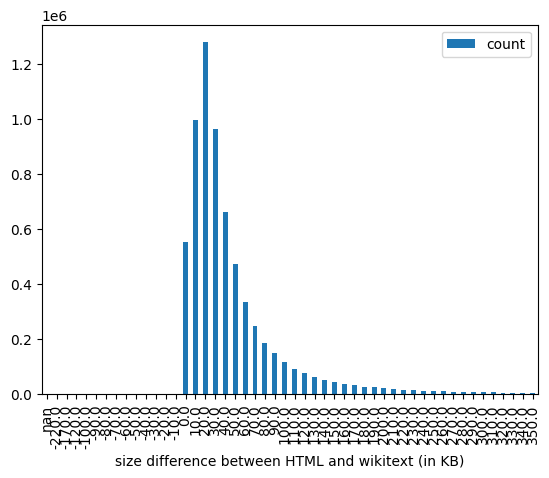

In [22]:
html_wikitext_diff_hist[:50].plot.bar('html_wikitext_diff','count',xlabel='size difference between HTML and wikitext (in KB)')